In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'playground-series-s4e6:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-competitions-data%2Fkaggle-v2%2F73290%2F8710574%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240626%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240626T045153Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D91f0ceebbbab4cc64081770e0aefb16516da0333200ca99327ab7bf828913845107b681882d1d6a4df068246f199956e9ef442f10b7f5e421f6759058e7b2d185a31e774c090f5d7e01c94c1b816ed078b17584e30090d61d5f7daf0f1edeba6e165c5ae3422675c6b35fc70af6c4103c74e99ff8a29e6990b3d7fc7a7e0816e70fcda71d6aeebb6f056b5add01018e64aa149c3497b26cbabe00b470647c1393538e2a3767b4954dc7b8377d3176012c76c6de7602cd9180cdffa72342b4fba54c0f48ec23127478ad3b8aaeb284503ab3e63447969dadc17a1f6296a4927e17485b26401c021bd22557784511f64e7afef6cdddcc456b00c96d9f93e7c8654'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 3217279 bytes downloaded
Downloaded and uncompressed: playground-series-s4e6
Data source import complete.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Classification with academic success datasets

## 1. Imports

In [ ]:
!pip install pytorch-tabnet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.5/44.5 kB 626.0 kB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-m

In [ ]:
!pip install ydata_profiling

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 359.5/359.5 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.8/104.8 kB 10.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 686.1/686.1 kB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.5/296.5 kB 15.4 MB/s eta 0:00:00
  Created wheel for htmlmin: filename=htmlmin-0.1.12-py3-none-any.whl size=27080 sha256=d28e175dbf543fd8e278008faea5435e3b88a51245a3e4c7102635f60d225a97
  Stored in directory: /root/.cache/pip/wheels/dd/91/29/a79cecb328d01739e64017b6fb9a1ab9d8cb1853098ec5966d
Successfully built htmlmin


In [ ]:
import os
import numpy as np
import pandas as pd

# visualize
import matplotlib.pyplot as plt
import seaborn as sns
import ydata_profiling

# training
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from pytorch_tabnet.tab_model import TabNetClassifier

# scoring
from sklearn.metrics import accuracy_score

## 2. Data Loading and Overview
- use "ydata-profiling"
- check "Alerts"
    - https://docs.profiling.ydata.ai/latest/getting-started/concepts/#data-quality-alerts

In [ ]:
df_train = pd.read_csv("/kaggle/input/playground-series-s4e6/train.csv")
df_test = pd.read_csv("/kaggle/input/playground-series-s4e6/test.csv")
df_sample = pd.read_csv("/kaggle/input/playground-series-s4e6/sample_submission.csv")

In [ ]:
df_train

,id,Marital status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
0,0,1,1,1,9238,1,1,126.0,1,1,...,0,6,7,6,12.428571,0,11.1,0.6,2.02,Graduate
1,1,1,17,1,9238,1,1,125.0,1,19,...,0,6,9,0,0.000000,0,11.1,0.6,2.02,Dropout
2,2,1,17,2,9254,1,1,137.0,1,3,...,0,6,0,0,0.000000,0,16.2,0.3,-0.92,Dropout
3,3,1,1,3,9500,1,1,131.0,1,19,...,0,8,11,7,12.820000,0,11.1,0.6,2.02,Enrolled
4,4,1,1,2,9500,1,1,132.0,1,19,...,0,7,12,6,12.933333,0,7.6,2.6,0.32,Graduate
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76513,76513,1,17,1,9254,1,1,121.0,1,19,...,0,6,8,5,10.600000,0,13.9,-0.3,0.79,Graduate
76514,76514,1,1,6,9254,1,1,125.0,1,1,...,0,6,9,6,13.875000,0,9.4,-0.8,-3.12,Graduate
76515,76515,5,17,1,9085,1,1,138.0,1,37,...,0,5,8,5,11.400000,1,9.4,-0.8,-3.12,Enrolled
76516,76516,1,1,3,9070,1,1,136.0,1,38,...,0,6,0,0,0.000000,0,7.6,2.6,0.32,Dropout


In [ ]:
df_test

,id,Marital status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,...,Curricular units 1st sem (without evaluations),Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP
0,76518,1,1,1,9500,1,1,141.0,1,3,...,0,0,8,0,0,0.000000,0,13.9,-0.3,0.79
1,76519,1,1,1,9238,1,1,128.0,1,1,...,0,0,6,6,6,13.500000,0,11.1,0.6,2.02
2,76520,1,1,1,9238,1,1,118.0,1,1,...,0,0,6,11,5,11.000000,0,15.5,2.8,-4.06
3,76521,1,44,1,9147,1,39,130.0,1,1,...,0,3,8,14,5,11.000000,0,8.9,1.4,3.51
4,76522,1,39,1,9670,1,1,110.0,1,1,...,0,0,6,9,4,10.666667,2,7.6,2.6,0.32
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51007,127525,1,1,2,171,1,1,128.0,1,38,...,0,0,0,0,0,0.000000,0,15.5,2.8,-4.06
51008,127526,2,39,1,9119,1,19,133.1,1,19,...,0,0,5,5,0,0.000000,0,9.4,-0.8,-3.12
51009,127527,1,1,1,171,1,1,127.0,1,1,...,0,0,0,0,0,0.000000,0,15.5,2.8,-4.06
51010,127528,1,1,3,9773,1,1,132.0,1,19,...,0,0,6,9,3,13.000000,0,7.6,2.6,0.32


In [ ]:
profile_report_train = ydata_profiling.ProfileReport(df_train, minimal=True)
profile_report_test = ydata_profiling.ProfileReport(df_test, minimal=True)
profile_report_train

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
profile_report_test

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
# label encoding
encoder = LabelEncoder()
df_train['Target'] = encoder.fit_transform(df_train['Target'])

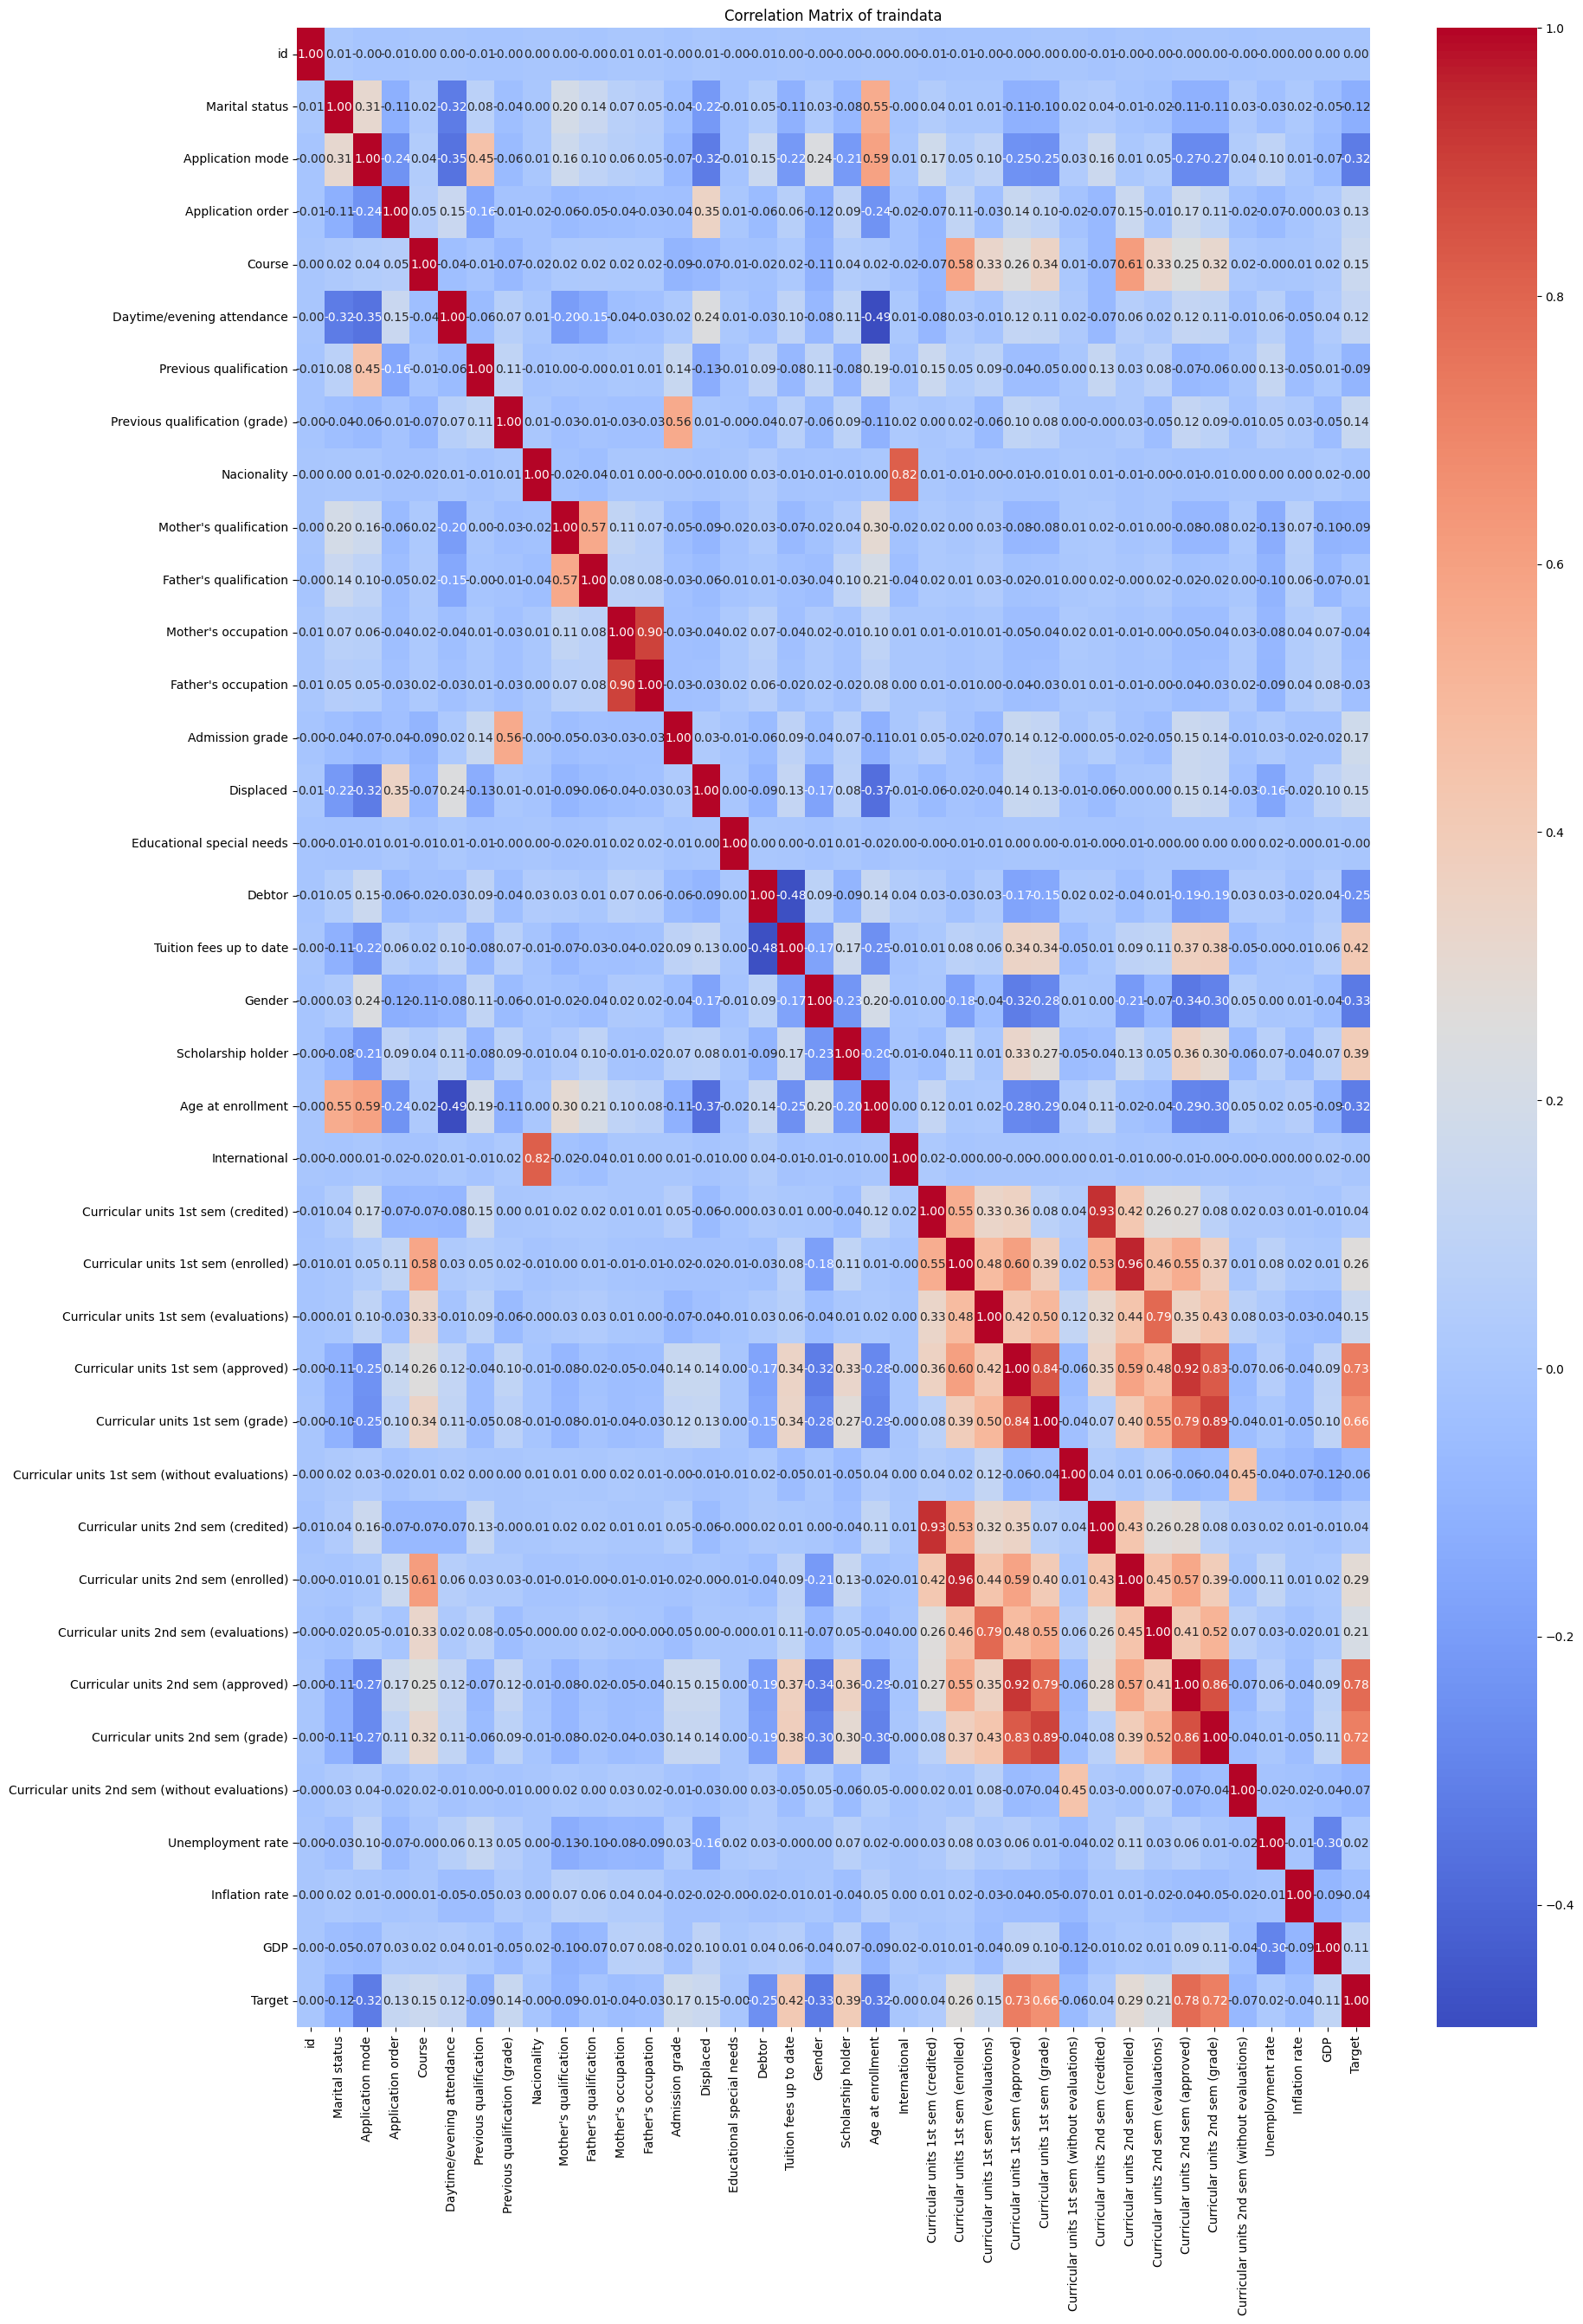

In [ ]:
corr_matrix = df_train.corr()
plt.figure(figsize=(20, 30))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of traindata')
plt.show()

### Cleansing

In [ ]:
# id
df_train = df_train.drop("id",axis = 1)
df_test = df_test.drop("id",axis = 1)

# Nacionality
df_train['Nacionality'] = np.log1p(df_train['Nacionality'])
df_test['Nacionality'] = np.log1p(df_train['Nacionality'])

In [ ]:
# against multicollinearity
high_corr_pairs = []
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

for column in upper.columns:
    for index in upper.index:
        corr_value = upper.loc[index, column]
        if abs(corr_value) >= 0.8:
            high_corr_pairs.append((index, column, corr_value))

for pair in high_corr_pairs:
    print(f"{pair[0]} and {pair[1]}: {pair[2]:.2f}")

to_drop = []
target_corr = df_train.corr()['Target']
for pair in high_corr_pairs:
    feature1, feature2, corr_value = pair
    print(f"【{feature1}】 target corr:", abs(target_corr[feature1]))
    print(f"【{feature2}】 target corr:", abs(target_corr[feature2]))
    if abs(target_corr[feature1]) > abs(target_corr[feature2]):
        to_drop.append(feature2)
    else:
        to_drop.append(feature1)
    print("*"*30)

to_drop = list(set(to_drop))
# drop lose column...
df_train.drop(columns=to_drop, inplace=True)
df_test.drop(columns=to_drop, inplace=True)

Mother's occupation and Father's occupation: 0.90
Nacionality and International: 0.82
Curricular units 1st sem (approved) and Curricular units 1st sem (grade): 0.84
Curricular units 1st sem (credited) and Curricular units 2nd sem (credited): 0.93
Curricular units 1st sem (enrolled) and Curricular units 2nd sem (enrolled): 0.96
Curricular units 1st sem (approved) and Curricular units 2nd sem (approved): 0.92
Curricular units 1st sem (approved) and Curricular units 2nd sem (grade): 0.83
Curricular units 1st sem (grade) and Curricular units 2nd sem (grade): 0.89
Curricular units 2nd sem (approved) and Curricular units 2nd sem (grade): 0.86
【Mother's occupation】 target corr: 0.04315650691802553
【Father's occupation】 target corr: 0.03264604598072674
******************************
【Nacionality】 target corr: 0.0029572304868790314
【International】 target corr: 0.0003259952888473587
******************************
【Curricular units 1st sem (approved)】 target corr: 0.7254903556449337
【Curricular u

In [ ]:
print("shape of cleansed df_train:",df_train.shape)
print("shape of cleansed df_test:",df_test.shape)

shape of cleansed df_train: (76518, 30)
shape of cleansed df_test: (51012, 29)


## 3. Modeling
- use pytorch-tabnet

In [ ]:
X = df_train.drop(['Target'], axis=1)
y = df_train['Target']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
X_train.isnull().sum()

Marital status                                    0
Application mode                                  0
Application order                                 0
Course                                            0
Daytime/evening attendance                        0
Previous qualification                            0
Previous qualification (grade)                    0
Nacionality                                       0
Mother's qualification                            0
Father's qualification                            0
Mother's occupation                               0
Admission grade                                   0
Displaced                                         0
Educational special needs                         0
Debtor                                            0
Tuition fees up to date                           0
Gender                                            0
Scholarship holder                                0
Age at enrollment                                 0
Curricular u

In [ ]:
y_train.isnull().sum()

0

In [ ]:
tabnet_classier = TabNetClassifier()
tabnet_classier.fit(
    X_train.values, y_train,
    max_epochs=1,
    patience=10,
    batch_size=1024,
    virtual_batch_size=128,
    num_workers=1,
    drop_last=False
)

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.8427  |  0:00:03s


In [ ]:
# validation
y_val_pred = tabnet_classier.predict(X_val.values)
val_accuracy = accuracy_score(y_val, y_val_pred)
print("val_accuracy:", val_accuracy)

val_accuracy: 0.8193936225823314


### full data training

In [ ]:
tabnet_classier = TabNetClassifier()
tabnet_classier.fit(
    X.values, y,
    max_epochs=100,
    patience=10,
    batch_size=1024,
    virtual_batch_size=128,
    num_workers=1,
    drop_last=False
)

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.74351 |  0:00:03s
epoch 1  | loss: 0.53114 |  0:00:07s
epoch 2  | loss: 0.52115 |  0:00:12s
epoch 3  | loss: 0.51603 |  0:00:16s
epoch 4  | loss: 0.50817 |  0:00:20s
epoch 5  | loss: 0.50184 |  0:00:25s
epoch 6  | loss: 0.49831 |  0:00:28s
epoch 7  | loss: 0.49742 |  0:00:32s
epoch 8  | loss: 0.49617 |  0:00:36s
epoch 9  | loss: 0.49514 |  0:00:41s
epoch 10 | loss: 0.49452 |  0:00:45s
epoch 11 | loss: 0.49597 |  0:00:48s
epoch 12 | loss: 0.50222 |  0:00:54s
epoch 13 | loss: 0.49782 |  0:00:58s
epoch 14 | loss: 0.49533 |  0:01:01s
epoch 15 | loss: 0.4948  |  0:01:06s
epoch 16 | loss: 0.49539 |  0:01:10s
epoch 17 | loss: 0.49353 |  0:01:14s
epoch 18 | loss: 0.49193 |  0:01:19s
epoch 19 | loss: 0.49208 |  0:01:22s
epoch 20 | loss: 0.49166 |  0:01:26s
epoch 21 | loss: 0.49191 |  0:01:31s
epoch 22 | loss: 0.49071 |  0:01:35s
epoch 23 | loss: 0.48957 |  0:01:39s
epoch 24 | loss: 0.48778 |  0:01:43s
epoch 25 | loss: 0.48795 |  0:01:48s
epoch 26 | loss: 0.48827 |  0:01:51s
e

In [ ]:
test_pred = tabnet_classier.predict(df_test.values)
# Decode
test_pred_decoded = encoder.inverse_transform(test_pred)
test_pred_decoded

array(['Dropout', 'Graduate', 'Graduate', ..., 'Dropout', 'Dropout',
       'Dropout'], dtype=object)

In [ ]:
df_submission = pd.DataFrame(
    {
        'id': df_sample['id'],
        'Target': test_pred_decoded
    }
)
df_submission.to_csv("submission_pytorch.csv", index=False)

from google.colab import files
files.download('submission_pytorch.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>